In [ ]:
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [1]:
import functions
# human = functions.Human()

In [2]:
help(functions.chunks)

Help on function chunks in module functions:

chunks(l, n)
    Yield successive n-sized chunks from l
    
    Parameters
    ----------
    l : list
        List of objects
    n : int
        Number of elements in each returned sub-list
    
    Returns
    -------
    generator
        A generator object of l split into n-sized chunks
    
    Examples
    --------
    >>> a = [3, 4, 5, 6, 7, 8, 9, 1, 2, 3, 4, 5, 6, 7, 8]
    >>> b = chunks(a, 3)
    >>> b
    <generator object chunks at 0x000001B078A8DE60>
    >>> list(b)
    [[3, 4, 5], [6, 7, 8], [9, 1, 2], [3, 4, 5], [6, 7, 8]]
    >>> c = chunks(a, 6)
    >>> list(c)
    [[3, 4, 5, 6, 7, 8], [9, 1, 2, 3, 4, 5], [6, 7, 8]]



In [2]:
# Load weather from MongoDB
home_ip = "192.168.1.80"
work_ip = "172.16.38.51"
weather = functions.load_mongo_weather(work_ip, 27017)

# Load weather from local EPW file
path = r"C:\Users\tgerrish\OneDrive - BuroHappold\0000000 Non-project\weather_files\DOE_EPW_files\ARE_Abu.Dhabi.412170_IWEC.epw"
weather = functions.load_epw_weather(path)

list(weather.keys())[:4]

['precipitableWater', 'timeZone', 'year', 'region']

In [9]:
def chunks(l, n):
    """ Yield successive n-sized chunks from l

    Parameters
    ----------
    l : list
        List of objects
    n : int
        Number of elements in each returned sub-list

    Returns
    -------
    generator
        A generator object of l split into n-sized chunks

    """

    for i in range(0, len(l), n):
        yield l[i:i + n]

list(chunks([3, 4, 5, 6, 7, 8, 9, 1, 2, 3, 4, 5, 6, 7, 8], 6))

[[3, 4, 5, 6, 7, 8], [9, 1, 2, 3, 4, 5], [6, 7, 8]]

In [3]:
# For a time of the year, for the selected weatherfile - get the solar adjusted MRT value

from datetime import datetime, timedelta

path = r"C:\Users\tgerrish\OneDrive - BuroHappold\0000000 Non-project\weather_files\DOE_EPW_files\ARE_Abu.Dhabi.412170_IWEC.epw"

weather = functions.load_epw_weather(path)
tz = weather["timeZone"]
lat = weather["latitude"]
lon = weather["longitude"]
hour_in_year = 1
d = datetime(1989, 1, 1, 13, 0, 0) + timedelta(hours=hour_in_year)

solar_altitude = functions.solar_altitude(latitude=lat, longitude=lon, year=d.year, month=d.month, day=d.day, hour=d.hour, minute=d.minute, second=d.second, time_zone=tz)
solar_azimuth = functions.solar_azimuth(latitude=lat, longitude=lon, year=d.year, month=d.month, day=d.day, hour=d.hour, minute=d.minute, second=d.second, time_zone=tz)

dbt = weather["dryBulbTemperature"]["values"][hour_in_year]
ghr = weather["globalHorizontalRadiation"]["values"][hour_in_year]
wnd = weather["windSpeed"]["values"][hour_in_year]
rh = weather["relativeHumidity"]["values"][hour_in_year]

solar_mrt = functions.solar_adjusted_mean_radiant_temperature(
                dry_bulb_temperature=dbt,
                diffuse_horizontal_radiation=weather["diffuseHorizontalRadiation"]["values"][hour_in_year],
                global_horizontal_radiation=ghr,
                direct_normal_radiation=weather["directNormalRadiation"]["values"][hour_in_year],
                solar_azimuth=solar_azimuth,
                solar_altitude=solar_altitude,
                clothing_absorbtivity=0.7,
                ground_reflectivity=0.4,
                shading_transmissivity=1
            )

utci = functions.universal_thermal_climate_index(air_temperature=dbt, mean_radiant_temperature=solar_mrt, air_velocity=wnd, relative_humidity=rh)
_set = functions.standard_effective_temperature(air_temperature=dbt, mean_radiant_temperature=solar_mrt, air_velocity=wnd, relative_humidity=rh, metabolic_rate=1, clo_value=1)
print(solar_altitude, solar_azimuth)
dbt, ghr, solar_mrt, utci, _set

37.296422345342016 207.76861267512547


(15.6, 0.0, 15.6, 14.212637417297172, 14.522806183485025)

In [7]:
# Approximating Fangers standing/sitting exposure level
functions.fanger_solar_exposure(altitude=9, azimuth=90)

0.3218861041463852

In [12]:
# Approximate solar adjusted mrt
functions.solar_adjusted_mean_radiant_temperature(
    dry_bulb_temperature=22,
    diffuse_horizontal_radiation=50,
    global_horizontal_radiation=75,
    direct_normal_radiation=10,
    solar_azimuth=90,
    solar_altitude=45,
    clothing_absorbtivity=0.7,
    ground_reflectivity=0.4,
    shading_transmissivity=0.45
)

24.373267177941646

In [26]:
# Fix the solar az, alt values prior to fangerising
from datetime import datetime
import pandas as pd

path = r"C:\Users\tgerrish\OneDrive - BuroHappold\0000000 Non-project\weather_files\DOE_EPW_files\KEN_Kisumu.637080_SWERA.epw"
weather = functions.load_epw_weather(path)

dts = pd.DatetimeIndex(start="1989-01-01 00:00", end="1990-01-01 00:00", freq="60T", closed="left")

tz = weather["timeZone"]
lat = weather["latitude"]
lon = weather["longitude"]
d = datetime(1989, 1, 1, 0, 0, 0)

def convert_altitude_azimuth(altitude, azimuth):
    if altitude < 0:
        altitude_adjusted = 0
    elif altitude > 90:
        altitude_adjusted = 90 - altitude
    else:
        altitude_adjusted = altitude

    if azimuth < 180:
        azimuth_adjusted = azimuth
    elif azimuth > 180:
        azimuth_adjusted = 360 - azimuth

    return altitude_adjusted, azimuth_adjusted

mrts = []
for r, d in enumerate(dts):
    if r % (24 * 7) == 0:
        print(d)
    alt, az = functions.sun_position(
            latitude=lat, longitude=lon, time_zone=tz, 
            year=d.year, month=d.month, day=d.day, hour=d.hour, minute=d.minute, second=d.second
    )
    alt, az = convert_altitude_azimuth(alt, az)
    
    exp = functions.fanger_solar_exposure(altitude=alt, azimuth=az)
    
    solAdjMRT = functions.solar_adjusted_mean_radiant_temperature(
                    dry_bulb_temperature=weather["dryBulbTemperature"]["values"][r],
                    diffuse_horizontal_radiation=weather["diffuseHorizontalRadiation"]["values"][r],
                    global_horizontal_radiation=weather["globalHorizontalRadiation"]["values"][r],
                    direct_normal_radiation=weather["directNormalRadiation"]["values"][r],
                    solar_azimuth=az,
                    solar_altitude=alt,
                    clothing_absorbtivity=0.7,
                    ground_reflectivity=0.4,
                    shading_transmissivity=1
                )
    mrts.append(solAdjMRT)
    

    #print("Hour: {2:02}:00 | Altitude: {0:6.2f}, Azimuth: {1:6.2f} | Exposure: {3:.3f} | Solar adjusted MRT: {4:.2f}".format(alt, az, r, exp, solAdjMRT))

1989-01-01 00:00:00
1989-01-08 00:00:00
1989-01-15 00:00:00
1989-01-22 00:00:00
1989-01-29 00:00:00
1989-02-05 00:00:00
1989-02-12 00:00:00
1989-02-19 00:00:00
1989-02-26 00:00:00
1989-03-05 00:00:00
1989-03-12 00:00:00
1989-03-19 00:00:00
1989-03-26 00:00:00
1989-04-02 00:00:00
1989-04-09 00:00:00
1989-04-16 00:00:00
1989-04-23 00:00:00
1989-04-30 00:00:00
1989-05-07 00:00:00
1989-05-14 00:00:00
1989-05-21 00:00:00
1989-05-28 00:00:00
1989-06-04 00:00:00
1989-06-11 00:00:00
1989-06-18 00:00:00
1989-06-25 00:00:00
1989-07-02 00:00:00
1989-07-09 00:00:00
1989-07-16 00:00:00
1989-07-23 00:00:00
1989-07-30 00:00:00
1989-08-06 00:00:00
1989-08-13 00:00:00
1989-08-20 00:00:00
1989-08-27 00:00:00
1989-09-03 00:00:00
1989-09-10 00:00:00
1989-09-17 00:00:00
1989-09-24 00:00:00
1989-10-01 00:00:00
1989-10-08 00:00:00
1989-10-15 00:00:00
1989-10-22 00:00:00
1989-10-29 00:00:00
1989-11-05 00:00:00
1989-11-12 00:00:00
1989-11-19 00:00:00
1989-11-26 00:00:00
1989-12-03 00:00:00
1989-12-10 00:00:00


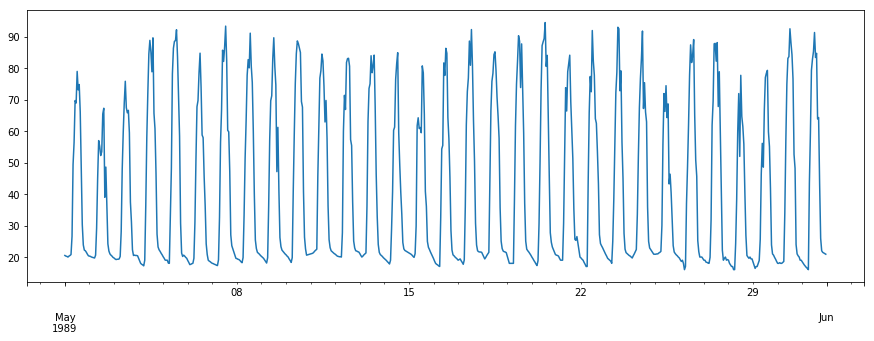

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt

data = pd.Series(data=mrts, index=dts)["1989-05"]
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
data.plot(ax=ax)

In [21]:
def get_input():
    command = input(": ").split()
    verb_word = command[0]
    if verb_word in verb_dict:
        verb = verb_dict[verb_word]
    else:
        print("Unknown verb {}". format(verb_word))
        return

    if len(command) >= 2:
        noun_word = command[1]
        print (verb(noun_word))
    else:
        print(verb("nothing"))

def say(noun):
    return 'You said "{}"'.format(noun)

class GameObject:
    class_name = ""
    desc = ""
    objects = {}

    def __init__(self, name):
        self.name = name
        GameObject.objects[self.class_name] = self

    def get_desc(self):
        return self.class_name + "\n" + self.desc

class Goblin(GameObject):
    class_name = "goblin"
    desc = "A foul creature"

goblin = Goblin("Gobbly")

def examine(noun):
    if noun in GameObject.objects:
        return GameObject.objects[noun].get_desc()
    else:
        return "There is no {} here.".format(noun)
    
verb_dict = {
    "say": say,
    "examine": examine,
}

get_input()

: elf
Unknown verb elf
